# Predicting House Sale Prices with Python
Kyle Schmidt
December 2019

## 1. Introduction
The [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) Kaggle competition provides a data set with 79 variables describing houses sold in Ames, Iowa. Sale prices are provided for half of the data to train a regression algorithm and sale prices are withheld on the other half for testing. After creating an algorithm and predicitng the house sale prices on the test data set, submissions are stored in csv format, uploaded to kaggle and scored with the root mean square error (rmse). The methods and processes in this Jupyter notebook resulted in a rmse score of 0.12402 placing me in the top 8% of all submissions.

My approach to the problem starts with exploring the data to get a better understanding of the size and types af variables I'm working with and to look for any potential problems with the data. After better understanding the data I move into pre-processing where I address issues with the data and prep the data for modeling. Once pre-processing is complete I use a stack of Ridge, Lasso, Elastic Net, XGBoost and Light Gradient Boosting regression techniques to maximize performance without overfitting.

## 2. Data Exploration
Data exploration is an important in the process of writing a regression algorithm. Understanding the data and the types of data you will be working with helps identify potential problems, issues and opportunities within the data.

### 2.1 Loading the required packages and importing the data
Before starting work on this data set I need to import data and packages into my workspace. Much of the work will be done using Pandas and Numpy with the help of several tools from sklearn.


In [1]:
# Import necessary packages
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None


# Load the data. Make sure to update the file paths to where you stored the data,
train = pd.read_csv('.../train.csv', delimiter=',')
test = pd.read_csv('.../test.csv', delimiter=',')


### 2.2 Exploration
I'll begin by looking at the amount of data, types of data and a smalle sample of each table (train and test).


In [2]:
# Print the data shapes.
print('Train data shape:')
print(train.shape)
print('---')
print('Test data shape:')
print(test.shape)
print('')

# Print the data types
print('Train data types:')
print(train.dtypes)
print('---')
print('Test data types:')
print(test.dtypes)
print('')

# Print a few rows of both data sets
print('Train data sample:')
print(train.head(5))
print('---')
print('Test data sample:')
print(test.head(5))


Train data shape:
(1460, 81)
---
Test data shape:
(1459, 80)

Train data types:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object
---
Test data types:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

Train data sample:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave

The train data has one more column than the test, which is dependant variable. Otherwise the data sets have the same columns and are close to the same size. There is a mix of categorical and numeric data. Some of the categorical data is ordinal and some is not.

It's obvious that the data needs some work, here is what I see right now:

* The Id column is just a counter and is not needed.
* Some of the categorical data is represented numerically. This might be okay if it is ordinal, but requires follow up.
* Some of the categorical data is ordinal and needs to be encoded.
* There is missing data.
* There are a couple combo-features that may be useful.

I will need to address each of these data issues. I'll delete the Id column now then work on imputing the missing data before addressing the other issues.


In [3]:
# Delete the unnecessary Id column from both data sets
del train['Id']
del test['Id']


### 2.3 The target variable
The target variable, SalePrice, is a discrete numerical value. I'll look at the distribution of the data.


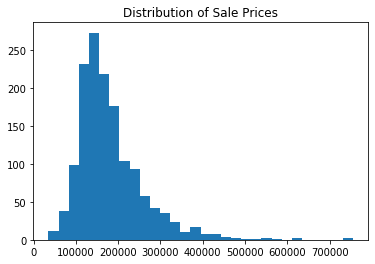

In [4]:
# Create histogram of sales prices.
plt.hist(train['SalePrice'], bins=30)
plt.title('Distribution of Sale Prices')
plt.show()


The distribution is a bit right skewed. A skewed distribution can make any outliers have too much influence and reduce the accuracy of the model. I'll perform a lof-transformation on the target variable to make the distribution more normal.


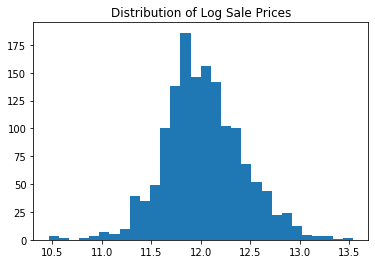

In [5]:
# Create a new column in the train data set for a log transformation of SalePrice
train['LogSalePrice'] = np.log(train['SalePrice'])

# Create histogram of Log sales prices to see the new distribution.
plt.hist(train['LogSalePrice'], bins=30)
plt.title('Distribution of Log Sale Prices')
plt.show()


This distribution looks much more normal than the original. To make sure it actually is normal I will create a Q-Q plot.

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.3982622308161888, 12.024050901109383, 0.9953761475636613))

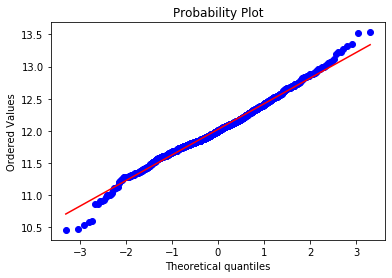

In [6]:
# Create a Q-Q plot to test for normality of the distribution
stats.probplot(train['LogSalePrice'], dist="norm", plot=plt)


Based on the Q-Q plot, the distribution is normal. I will continue my regression using the LogSalePrice, and will delete the SalePrice from my dataset. With a Log transform my regression algorithm will give me LogSalePrice as an output so I'll need to remember to transform those values back to SalePrice before submission.

There looks to be some departures from normality at the ends of the Q-Q plot line so I'll check for outliers using a z-score test.

The z-score gives an observation's position in relation to the mean of the values in terms of standard deviations. A z-score of 0 means the observation is right at the mean and a z-score of 1 means that observation is 1 standard deviation above the mean. According to the 68-95-99.7 rule, 99.7% of the values will be within 3 standard deviations of the mean for a normal distribution.

I will consider any observation more than 3 standard deviations from the mean an outlier and remove it form the data. In order to determine which observations are outliers I'll write a short function to identify the outliers.


In [7]:
# Delete original SalePrice column from the train dataset
del train['SalePrice']

# create a function to perform a z-test and returns any outliers.
def z_outlier(array):
    """takes an array of numbers calculates the z-score and returns the numbers with a z-score greater than 3"""
    array_mean = np.mean(array)
    std_dev = np.std(array)
    outliers = []
    for i in array:
        if ((i - array_mean)/std_dev) > 3:
            outliers.append(i)
        elif ((i - array_mean)/std_dev) < -3:
            outliers.append(i)
    return outliers

# Save outliers in list
outl = z_outlier(train['LogSalePrice'])
print(outl)


[10.596634733096073, 13.226723392728571, 10.460242108190519, 10.578979797857352, 13.534473028231162, 13.275827535915461, 13.323926946863102, 10.47194980911048, 10.542706391070517, 13.229567991666638, 13.345506928718539, 13.521139497361697]


The z-score test has identified 12 outliers. I'll remove these outliers from the data set.


In [8]:
# remove the outliers from the train data set
for outlier in outl:
    train = train[train.LogSalePrice != outlier]
    

Continuing with my exploration of the data I want to look at how each feature correlates to the target value. Before creating the correlation matrix there are 3 combination features I want to create.

Several of the features, to me, seem like one feature broken down into several sub categories. When I shop for a house I look at the number of bathrooms - I don't look at the number of bathrooms by floor so it makes sense to me that a single feature for number of bathrooms would be more valuable than individual features for bathroom location. The 3 new features will be TotalSF, TotalBath and YrFromRemod, representing the total square footage, total number of bathrooms and number of years from the last remodel (using 2011 as the year).

In [9]:
# Create 3 bew combo features in both the train and test data sets: TotalSF, YrFromRemod and TotalBath representing
# the total square footage of the house, the number of years since the last remodel and the total number of
# bathrooms.
# Train data
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

train['YrFromRemod'] = (2011 - train['YearRemodAdd'])

train['TotalBath'] = train['BsmtFullBath'] + (train['BsmtHalfBath']/2) + train['FullBath'] \
+ (train['HalfBath']/2)

# Test data
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

test['YrFromRemod'] = (2011 - test['YearRemodAdd'])

test['TotalBath'] = test['BsmtFullBath'] + (test['BsmtHalfBath']/2) + test['FullBath'] \
+ (test['HalfBath']/2)


With my new features added to the dataset I'll look at how each feature correlates to the LogSalePrice.


In [10]:
# calculate correlations and print correlations to the target variable
target_corr = train.corr()
print(target_corr['LogSalePrice'].head(80))


MSSubClass      -0.081231
LotFrontage      0.335597
LotArea          0.253800
OverallQual      0.808986
OverallCond     -0.049543
YearBuilt        0.586730
YearRemodAdd     0.563476
MasVnrArea       0.415172
BsmtFinSF1       0.355864
BsmtFinSF2      -0.001230
BsmtUnfSF        0.218351
TotalBsmtSF      0.596140
1stFlrSF         0.577144
2ndFlrSF         0.306183
LowQualFinSF    -0.039650
GrLivArea        0.687467
BsmtFullBath     0.239638
BsmtHalfBath    -0.016183
FullBath         0.582427
HalfBath         0.305932
BedroomAbvGr     0.192054
KitchenAbvGr    -0.154976
TotRmsAbvGrd     0.514748
Fireplaces       0.481892
GarageYrBlt      0.541007
GarageCars       0.674320
GarageArea       0.644909
WoodDeckSF       0.333106
OpenPorchSF      0.350378
EnclosedPorch   -0.143931
3SsnPorch        0.058304
ScreenPorch      0.115038
PoolArea         0.039009
MiscVal         -0.020830
MoSold           0.076677
YrSold          -0.037880
LogSalePrice     1.000000
TotalSF          0.766893
YrFromRemod 

It looks like the things you normally look for when house shopping: lot size, house square footage, number of bathrooms and overall quality are most highly correlated to the sale price.

The 3 combination features I created all look to have somewhat high correlations to the LogSalePrice.

If I was writing the regression model by hand this might be a good moment to think about feature selection and possibly removing some variables from the dataset. With Machine learning I am allowing the model to do the feature selection for me, so it is unnecessary in this setting.


## 3. Data Pre-Processing
Now that I have a better understanding of the types of data I am working with, I can start preparing the data for model building. With machine learning the variables need to be put in a format that the computer can understand. This process involves cleaning, encoding and tranforming the data. I have already identified a few issues to work on so I'll start with data cleaning.

### 3.1 Missing data
I previously identified that the data sets have missing data. First I'll look to see what is missing and how much of it is missing, then determine how to approach the issue.


In [11]:
# Identify the missing data
train_mis = train.isnull().sum().sort_values(ascending=False)
test_mis = test.isnull().sum().sort_values(ascending=False)

print('Train missing data:')
print(train_mis.head(20))
print('---')
print('Test missing data:')
print(test_mis.head(36))


Train missing data:
PoolQC          1442
MiscFeature     1394
Alley           1358
Fence           1171
FireplaceQu      685
LotFrontage      259
GarageCond        78
GarageYrBlt       78
GarageType        78
GarageFinish      78
GarageQual        78
BsmtExposure      37
BsmtFinType2      37
BsmtQual          36
BsmtCond          36
BsmtFinType1      36
MasVnrArea         8
MasVnrType         8
Electrical         1
BldgType           0
dtype: int64
---
Test missing data:
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageQual        78
GarageCond        78
GarageFinish      78
GarageYrBlt       78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
TotalBath          2
Functional         2
Utilities          2
GarageCars         1

There is a lot of missing data. For PoolQC 99% is missing!

A quick look at the data_description.txt file that comes with the data shows that an NA in PoolQC actually means that the house doesn't have a pool. None' would be more appropriate than NA because 0 is different than "I don't know". This same thing applies to several other variables.

Additionally, several variables use NA when 0 would be more approriate. I'll start data imputation by correcting these issues.


In [12]:
# Create lists of variables where NA's are to be replaced by either 'None' or 0.
none_fill = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 'GarageCond', 'GarageFinish',
             'GarageType', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'MasVnrType']

zero_fill = ['GarageYrBlt', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrArea', 'GarageCars', 'GarageArea', 'BsmtFinSF1',
             'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath']

# Replace NAs with appropriate 'None' or 0
for var in none_fill:
    train[var] = train[var].fillna('None')
    test[var] = test[var].fillna('None')
    
for var in zero_fill:
    train[var] = train[var].fillna(0)
    test[var] = test[var].fillna(0)
    
# Re-assess the staus of missing values
train_mis = train.isnull().sum().sort_values(ascending=False)
test_mis = test.isnull().sum().sort_values(ascending=False)

print('Train missing data:')
print(train_mis.head(3))
print('---')
print('Test missing data:')
print(test_mis.head(11))


Train missing data:
LotFrontage    259
Electrical       1
BsmtCond         0
dtype: int64
---
Test missing data:
LotFrontage     227
MSZoning          4
TotalBath         2
Utilities         2
Functional        2
Exterior2nd       1
KitchenQual       1
Exterior1st       1
SaleType          1
TotalSF           1
BsmtFinType2      0
dtype: int64


That fixed the majority of the issues. LotFrontage is the largest of the remaining missing values. I spent some time looking at the data and found that the LotFrontage value is very similar for houses within each neighborhood. For the missing LotFrontage values I will impute the median LotFrontage for the neighborhood in which the house resides.


In [13]:
# Calculate the median LotFrontage, grouped by neighborhood, then impute the missing LotFrontage values.
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Re-assess the staus of missing values
train_mis = train.isnull().sum().sort_values(ascending=False)
test_mis = test.isnull().sum().sort_values(ascending=False)

print('Train missing data:')
print(train_mis.head(2))
print('---')
print('Test missing data:')
print(test_mis.head(10))


Train missing data:
Electrical    1
RoofStyle     0
dtype: int64
---
Test missing data:
MSZoning        4
TotalBath       2
Functional      2
Utilities       2
SaleType        1
KitchenQual     1
Exterior2nd     1
TotalSF         1
Exterior1st     1
BsmtFinType1    0
dtype: int64


I am now down to just a handful of missing values. These will need to be assessed one-by-one.

Electrical:

The missing elecrtical value is for a house built in 2006. All houses in the data set built after 1965 have 'SBrkr' electrical.

In [14]:
train['Electrical'] = train['Electrical'].fillna('SBrkr')


MSZoning:

For zoning the same reasoning I used for LotFrontage holds true - neighborhoods tend to have the same zoning. The only difference is I will use mode, rather than median since it's categorical.

In [15]:
test['MSZoning'] = test.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


Functional:

94% of the data in the test set has a Functional classification of Typ and there weren't any obvious ways to group the non-Typ homes so I will impute Typ for these missing vlaues.


In [16]:
# Impute 'Typ' for missing Functional values
test['Functional'] = test['Functional'].fillna('Typ')


Utilites:

There is only one category in this field and only 2 observations that have NA. This variable will not have any predictive power in a model so I will just delete Utilities:


In [17]:
# Delete the 'Utilities' variable from both the train and test data sets
del train['Utilities']
del test['Utilities']


Exterior1st:

We have just one observation missing this variable. The home with the missing variable was built in 1940, remodeled in 2007 and is in the Edwards neighborhood. I don't see any obvious correlations between any of these variables and Exterior1st so I will impute the most common variable in this field

In [18]:
# Impute the mode of the 'Exterior1st' variable for the missing value
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])


SaleType:

There is a single SaleType variable missing. I do not see any obvious relationships between this and any other variables so I will impute the mode of the SaleType variable.


In [19]:
# Impute the mode of the 'SaleType' variable for the missing value
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])


Exterior2nd:

The single missing observation for this variable is the same observation that was missing the Exterior1st variable. I will use the same technique for imputation on this variable as I did with Exterior1st.

In [20]:
# Impute the mode of the 'Exterior2nd' variable for the missing value
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])


KitchenQual:

This is another single missing observation. I will impute the mode of the KitchenQual variable.

In [21]:
# Impute the mode of the 'KitchenQual' variable for the missing value
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])


TotalBath and TotalSF:

These are two of the combination features I had made. They are missing becuase I created these features before imputing the 0's in for NA's on some of the data. I just need to re-run the same code that created the features in the first place.


In [22]:
# Re-run the code to create the missing combination features
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

test['TotalBath'] = test['BsmtFullBath'] + (test['BsmtHalfBath']/2) + test['FullBath'] \
+ (test['HalfBath']/2)

# Re-assess the staus of missing values
train_mis = train.isnull().sum().sort_values(ascending=False)
test_mis = test.isnull().sum().sort_values(ascending=False)

print('Train missing data:')
print(train_mis.head(5))
print('---')
print('Test missing data:')
print(test_mis.head(5))

Train missing data:
TotalBath      0
RoofMatl       0
Exterior2nd    0
MasVnrType     0
MasVnrArea     0
dtype: int64
---
Test missing data:
TotalBath      0
CentralAir     0
Exterior1st    0
Exterior2nd    0
MasVnrType     0
dtype: int64


### 3.2 Ordinal data
Now that missing data is taken care of I can move on to makeing sure the different types of data are in the correct format.

Ordinal data is treated differently from other categorical data because, as the name implies, the order of the data gives us additional information. I am going to encode the ordinal data so that we retain that additional information once I start making my model.

During data examination I mentioned there is some categorical data that is represented numerically. I will convert these to string data types.


In [23]:
# Create a list of the numerically represented categorical data
numcat = ['MSSubClass','MoSold', 'YrSold']

# Change the data type to string for each numerically represented ordinal data
for var in numcat:
    train[var] = train[var].apply(str)
    test[var] = test[var].apply(str)
    

Encoding ordinal data assigns a number to each category. Since order matters I'll need to do this manually rather than letting the computer do it. If I were to use something like the sklearn ordinal encoder it would just apply a 1 to the first category it came across, then a 2 to the next and so on. This would screw up the order of the ordinal categories.


In [24]:
# map ordered values to associated number
ordinal_map = {
    'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtQual': {'None': 1, 'Po':2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6},
    'BsmtCond': {'None': 1, 'Po':2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6},
    'BsmtExposure': {'None': 1, 'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5},
    'BsmtFinType1': {'None': 1, 'Unf': 2, 'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7},
    'BsmtFinType2': {'None': 1, 'Unf': 2, 'LwQ': 3, 'Rec': 4, 'BLQ': 5, 'ALQ': 6, 'GLQ': 7},
    'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'CentralAir': {'N': 1, 'Y': 2},
    'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'Functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8},
    'FireplaceQu': {'None': 1, 'Po':2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6},
    'GarageFinish': {'None': 1, 'Unf': 2, 'RFn': 3, 'Fin': 4},
    'GarageQual': {'None': 1, 'Po':2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6},
    'GarageCond': {'None': 1, 'Po':2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6},
    'PoolQC': {'None': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    }

# replace the ordinal values with the new values
train.replace(ordinal_map, inplace=True)
test.replace(ordinal_map, inplace=True)


### 3.3 Categorical data
The non-ordinal categorical variables need to be encoded as well. Order is not important for the non-ordinal categorical data so I can treat it differently from the ordinal data. I will be one-hot encoding the categorical data. One-hot encoding creates a column for each category and has a binary indicator (0 or 1) on each observation for each category. One-hot encoding allows us to translate string categories (human readable) into numerical categories (computer readable) without implying an order to the categories.

To one-hot encode the categorical variables I need to do a few things. First I need to combine the train and test data sets. If I were to one hot encode the data sets separately I would likely get a different number of columns and different column positions.The order which the categories appear in each dataset are different and all of the variables aren't present in both data sets. Before I can combine the datasets I need to remove the LogSalePrice dependant variable from the train data set so the train and test data have the same number of columns.


In [25]:
# Seperate the dependant variable from the train data
train_y = train.pop('LogSalePrice')

# Combine the train and test data
all_data = pd.concat(objs=[train, test], axis=0)

# View the size of the new data set
print('all_data shape:')
print(all_data.shape)


all_data shape:
(2907, 81)


With the train and test data combined, I need to separate the numerical and ordinal data from the categorical data. I do not want to one-hot encode the ordinal or numerical data.


In [26]:
# Separate categorical and numerical data
num_all_data = all_data.select_dtypes(include=[np.number])
cat_all_data = all_data.select_dtypes(exclude=[np.number])

# View the shape of the new data sets
print('num_all_data shape:')
print(num_all_data.shape)
print('---')
print('cat_all_data shape:')
print(cat_all_data.shape)


num_all_data shape:
(2907, 50)
---
cat_all_data shape:
(2907, 31)


With the train and test data combined and the numerical and categorical variables separated I can one-hot encode the categorical variables using pandas.get_dummies.


In [27]:
# One-hot encode categorical variables
cat_all_data = pd.get_dummies(cat_all_data)

# View new data shape
print('cat_all_data shape')
print(cat_all_data.shape)


cat_all_data shape
(2907, 226)


One hot encoding made the dataset much larger. I went from 31 categorical variables to 226. Some of the variables are very sparse in usage. I'm going to remove those with fewer than 15 observations (used on fewer than ~0.5% of observations).


In [28]:
# Delete columns with fewer than 15 observations
for var in list(cat_all_data.columns.values):
    if cat_all_data[var].sum() < 15:
        del cat_all_data[var]
        
print('cat_all_data shape:')
print(cat_all_data.shape)


cat_all_data shape:
(2907, 172)


### 3.4 Numerical data
Lastly, I'll be transforming the numeric data to a standarized format. Standardization takes each numerical variables and makes the mean of the those values 0 and the standard deviation 1. This puts all of the numeric values on the same scale. Standardization makes sense because we don't really care about what scale the values are on and it's a bit easier to have all the varibales on the same scale, while retaining their variance in relation to the other values.

Right now my numeric dataset includes the ordinal data. I do not want to standardize the ordinal data because the standardization would be meaningless - with ordinal data the only thing that matters is the rank. After separating my ordinal data from my numeric, I'll standardize the numeric data and rebind the data together.


In [29]:
# Make data frame of the ordinal data
ord_all_data = num_all_data.filter(items=ordinal_map.keys())

# Make list of numerical column headers
num_cols = list(num_all_data.columns.values) - ordinal_map.keys()

# Make df of only the numerical data
num_all_data = num_all_data.filter(items=num_cols)


The data is separated, so now to standardize the numerical data I'll use sklearn standard scaler.


In [30]:
# Standardize the numerical data
scaler = StandardScaler()
scaled_num_data = scaler.fit_transform(num_all_data)

# Output is a numpy array and I want a pandas df. I'll first extract the column headers, then convert the numpyp
# array to a pandas df then add the column headers back in
col_names = list(num_all_data.columns.values)
num_all_data = pd.DataFrame(scaled_num_data)
num_all_data.columns = col_names

# View a sample of the standardized data
print('num_all_data shape:')
print(num_all_data.shape)
print('---')
print(num_all_data.head(5))


num_all_data shape:
(2907, 36)
---
   YearBuilt  WoodDeckSF  GrLivArea  HalfBath  EnclosedPorch  BsmtHalfBath  \
0   1.047503   -0.740977   0.427202  1.233699      -0.359345     -0.249490   
1   0.154989    1.615832  -0.474595 -0.755410      -0.359345      3.825049   
2   0.981390   -0.740977   0.580185  1.233699      -0.359345     -0.249490   
3  -1.861429   -0.740977   0.441292 -0.755410       3.872831     -0.249490   
4   0.948334    0.777504   1.409516  1.233699      -0.359345     -0.249490   

   1stFlrSF  OpenPorchSF  BsmtFullBath  MasVnrArea  ...  PoolArea  BsmtFinSF1  \
0 -0.777076     0.204751      1.086972    0.543534  ... -0.060481    0.588350   
1  0.266946    -0.704969     -0.818835   -0.570713  ... -0.060481    1.189439   
2 -0.612501    -0.078605      1.086972    0.350246  ... -0.060481    0.102175   
3 -0.507070    -0.182999      1.086972   -0.570713  ... -0.060481   -0.494494   
4 -0.033918     0.547759      1.086972    1.419013  ... -0.060481    0.475646   

   TotRms

### 3.5 Finalizing Pre-processing
I am almost ready to build the model, but before I do that I need to combine all the columns back together, check for high levels of covariation among variables and remove any highly correlated variables and re-separate the train and test sets.

I'll start this process by putting the ordinal and numerical data back together.


In [31]:
# make sure the data sets all have the same number of rows
print('num_all_data shape:')
print(num_all_data.shape)
print('---')
print('ord_all_data shape:')
print(ord_all_data.shape)
print('---')
print('cat_all_data shape:')
print(cat_all_data.shape)
print('---')

# The row indices need to be reset for pd.concat to work
num_all_data.reset_index(drop=True, inplace=True)
ord_all_data.reset_index(drop=True, inplace=True)
cat_all_data.reset_index(drop=True, inplace=True)

# Combine the numeric and ordinal data sets
numord = pd.concat([num_all_data, ord_all_data], axis=1)


num_all_data shape:
(2907, 36)
---
ord_all_data shape:
(2907, 14)
---
cat_all_data shape:
(2907, 172)
---


Now, I'll check for covariation. I want to remove variables that very high levels of covariance but I want to put a little bit of thought into it. For instance in image classification each feature is a pixel and neighboring pixels will likely be highly correlated, but removing that many features would wreck your model.

I am going to look at the highly correlated variables and think about why they are highly correlated. If the variables represent the same underlying information then they are likely just doubling the power of a single piece of data.


In [32]:
# create correlation matrix and check for high correlations
correl = numord.corr().unstack().sort_values()
correl_rev = numord.corr().unstack().sort_values(ascending=False).drop_duplicates()
print(correl.head(10))
print('---')
print(correl_rev.head(10))

# Delete highly correlated features
del numord['YearRemodAdd']
del numord['GarageYrBlt']
del numord['GarageArea']
del numord['GrLivArea']
del numord['FireplaceQu']
del numord['TotalBsmtSF']


YrFromRemod   YearRemodAdd   -1.000000
YearRemodAdd  YrFromRemod    -1.000000
KitchenQual   YrFromRemod    -0.612569
YrFromRemod   KitchenQual    -0.612569
YearBuilt     YrFromRemod    -0.609985
YrFromRemod   YearBuilt      -0.609985
ExterQual     YrFromRemod    -0.606265
YrFromRemod   ExterQual      -0.606265
              OverallQual    -0.569073
OverallQual   YrFromRemod    -0.569073
dtype: float64
---
PoolQC        PoolQC          1.000000
GarageYrBlt   GarageCond      0.949011
GarageArea    GarageCars      0.888818
TotalSF       GrLivArea       0.862508
FireplaceQu   Fireplaces      0.861641
TotalSF       TotalBsmtSF     0.826535
GrLivArea     TotRmsAbvGrd    0.807864
1stFlrSF      TotalBsmtSF     0.797300
TotalSF       1stFlrSF        0.789505
BsmtFinType2  BsmtFinSF2      0.766760
dtype: float64


I found 6 pairs of highly correlated variables that seemed to represent the same underlying data. For example GarageYrBlt and GarageCond both are likely descriptive of the condition of the garage. I chose to delete GarageYrBlt because it has a lower correlation value to LogSalePrice than GarageCond.

Now I just need to add the categorical data back in, separate the train and test set and I am ready to build my model!

In [33]:
# Combine the numerical, ordinal and categorical features
preproc_all_data = pd.concat([numord, cat_all_data], axis=1)

# Print new data set shape
print('preproc_all_data shape:')
print(preproc_all_data.shape)
print('---')

# Re-separate the train and test sets
preproc_train = preproc_all_data[:len(train)]
preproc_test = preproc_all_data[len(train):]

# Check shape to make sure the sets were separated correctly
print('preproc_train shape:')
print(preproc_train.shape)
print('---')
print('preproc_test shape:')
print(preproc_test.shape)
print('---')


preproc_all_data shape:
(2907, 216)
---
preproc_train shape:
(1448, 216)
---
preproc_test shape:
(1459, 216)
---


## 4. Model Building
I'll be stacking several regression methods (Ridge, Lasso, Elastic Net, XGBoost and Light Gradient Boosting) to try and get the best results without overfitting. 

Regression stacking takes several models, such as the five I'm using, makes predictions using each model then creates a new dataset of those predicitons. The dataset made up of those predictions is then put through a secondary regressor to get the final results. regression stacking is very computationally heavy so it is best used on smaller datasets.

I'll be using k-fold cross validation with k=10 to evaluate and compare each model and I'll use the best performing model as the secondary regressor.

In [34]:
# k-fold cross validation method
kfold = KFold(n_splits = 10, shuffle=True, random_state=1951)

# The competition is on the RMSE so I'll create a function to get the CV RSME
def cv_rmse(reg_mod, x, y):
    return np.sqrt(-cross_val_score(reg_mod, x, y, scoring="neg_mean_squared_error", cv=kfold))

# Define the alphas to test
rr_alphas = np.linspace(14, 16, 21)
las_alphas = np.linspace(0.0001, 0.001, 10)
enet_alphas = np.linspace(0.0001, 0.001, 10)


# Create model pipelines
rr = make_pipeline(RidgeCV(alphas=rr_alphas, cv=kfold))

lasso = make_pipeline(LassoCV(max_iter=10000, alphas=las_alphas, random_state=1951, cv=kfold))

enet = make_pipeline(ElasticNetCV(max_iter=10000, alphas=enet_alphas, cv=kfold))

xgb = XGBRegressor(n_estimators=3000, max_depth=3, min_child_weight=1, subsample=0.75, colsample_bytree=0.5,
                   nthread=-1, random_state=1951, objective='reg:squarederror')

lgbm = LGBMRegressor(num_leaves=6, learning_rate=0.01, n_estimators=3000, max_bin=125, bagging_fraction=0.8,
                     bagging_freq=5, bagging_seed=6, feature_fraction=0.2, feature_fraction_seed=6,verbose=-1)

The model pipelines are built, I'll compare the scores (lower is better).

In [35]:
# Print the average cross validation RMSE for each model
print('Ridge regression average RMSE:')
print(cv_rmse(rr, preproc_train, train_y).mean())
print('---')

print('Lasso regression average RMSE:')
print(cv_rmse(lasso, preproc_train, train_y).mean())
print('---')
      
print('ElasticNet regression average RMSE:')
print(cv_rmse(enet, preproc_train, train_y).mean())
print('---')
      
print('XGBoost regression average RMSE:')
print(cv_rmse(xgb, preproc_train, train_y).mean())
print('---')

print('LGBM regression average RMSE:')
print(cv_rmse(lgbm, preproc_train, train_y).mean())


Ridge regression average RMSE:
0.12895556451052964
---
Lasso regression average RMSE:
0.1294129036344291
---
ElasticNet regression average RMSE:
0.1288794920384742
---
XGBoost regression average RMSE:
0.1139048586311368
---
LGBM regression average RMSE:
0.10985568523322146


The models are fit and the scores all look pretty good. LGBM gave me the best results so I'm going to use that as my secondary regressor and use all the models in my regression stack.

I'll build my regression stack and try it out on the test data.


In [36]:
stack = StackingCVRegressor(regressors=[rr, lasso, enet, xgb, lgbm], meta_regressor=lgbm,
                           use_features_in_secondary=True)

stack.fit(np.array(preproc_train), np.array(train_y))
stack_pred = stack.predict(np.array(preproc_train))

print("Stack RMSE on test:")
print(mean_squared_error(train_y, stack_pred))


Stack RMSE on test:
0.0035647909599203827


Finally, fit the test data, create the submission csv and submit. Make sure to add the file path to where you would like the submission stored.


In [37]:
stack_test_pred = stack.predict(np.array(preproc_test))

predictions = np.exp(stack_test_pred)

results = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': predictions})

results.to_csv('.../submission.csv', index=False)